In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *

from keras.models import Sequential,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
training_path="/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train"
validation_path="/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation"
testing_path="/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test"

In [3]:
train_gen = ImageDataGenerator(
    rescale = 1./255,
    zoom_range = 0.2,
    horizontal_flip  = True,
    rotation_range = 40,
    fill_mode = 'nearest'
)
test_gen=ImageDataGenerator(rescale = 1./255)

In [4]:
train_data=train_gen.flow_from_directory(training_path,target_size=(224,224),batch_size=32,class_mode="binary")

valid_data=test_gen.flow_from_directory(validation_path,target_size=(224,224),batch_size=32,class_mode="binary")

test_data=test_gen.flow_from_directory(testing_path,target_size=(224,224),batch_size=32,class_mode="binary")

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [5]:
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
callbacks = [
    EarlyStopping(monitor = 'accuracy', patience = 3), # I want to stop training earlier if i see no changes after 3 iterations in an epoch
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-2), # Here is the metric which i will check during training. If I see that val_loss doesnt change after 5 iterations, it stops earlier
    ModelCheckpoint(filepath='weights.h5', save_weights_only=True, monitor='val_accuracy',mode='max', save_best_only=True), # Here is just checkpoint which we can use after training (for example)
    LearningRateScheduler(scheduler), # here I use my learning rate changer (which is written above in the method)
    
]

In [7]:
baseModel = VGG16(weights="imagenet", include_top=False, input_shape = (224, 224, 3))
baseModel.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [8]:
model = Sequential()
model.add(baseModel)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 21,153,985
Trainable params: 6,439,297
Non

In [12]:
hist=model.fit(train_data, batch_size = 32,epochs = 15,validation_data = valid_data,callbacks = callbacks)

Epoch 1/15
313/313 [==============================] - 137s 438ms/step - loss: 0.0364 - accuracy: 0.9885 - val_loss: 0.0165 - val_accuracy: 0.9950 - lr: 8.1873e-04
Epoch 2/15
313/313 [==============================] - 136s 435ms/step - loss: 0.0306 - accuracy: 0.9904 - val_loss: 0.0139 - val_accuracy: 0.9950 - lr: 8.1873e-04
Epoch 3/15
313/313 [==============================] - 136s 435ms/step - loss: 0.0347 - accuracy: 0.9882 - val_loss: 0.0048 - val_accuracy: 0.9987 - lr: 8.1873e-04
Epoch 4/15
313/313 [==============================] - 136s 433ms/step - loss: 0.0302 - accuracy: 0.9893 - val_loss: 0.0100 - val_accuracy: 0.9950 - lr: 7.4082e-04
Epoch 5/15
313/313 [==============================] - 136s 433ms/step - loss: 0.0273 - accuracy: 0.9919 - val_loss: 0.0142 - val_accuracy: 0.9925 - lr: 6.7032e-04
Epoch 6/15
313/313 [==============================] - 139s 443ms/step - loss: 0.0255 - accuracy: 0.9916 - val_loss: 0.0112 - val_accuracy: 0.9962 - lr: 6.0653e-04
Epoch 7/15
313/313 [==

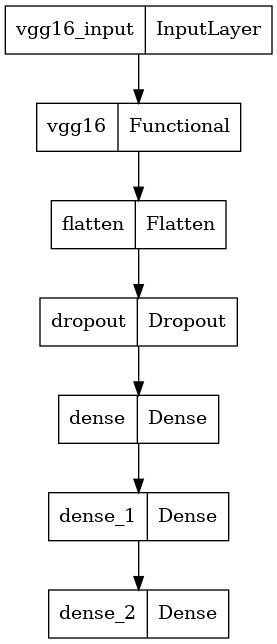

In [13]:
#Plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [14]:
model.evaluate(test_data)

31/31 [==============================] - 9s 281ms/step - loss: 0.0070 - accuracy: 0.9970


[0.00704181008040905, 0.9969757795333862]

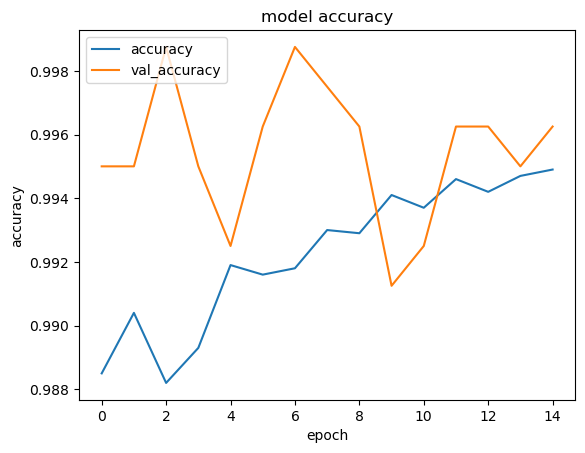

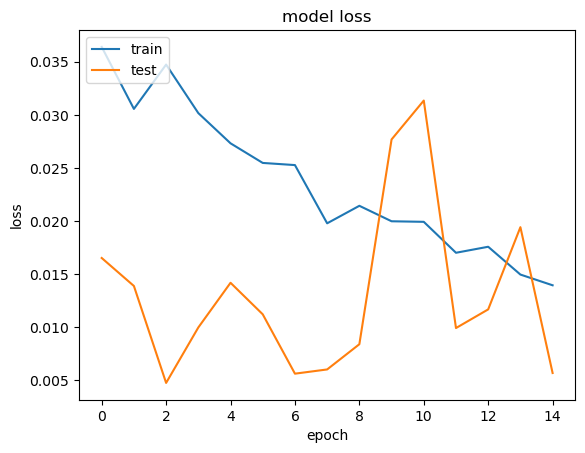

In [20]:

def display_accuracy() -> None:
    # Summarize history for accuracy
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
    plt.savefig('face_ac.png')
    plt.show()
    

def display_loss() -> None:
    # Summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('face_val.png')
    plt.show()
    

display_accuracy()
display_loss()

<Figure size 640x480 with 0 Axes>

In [17]:
model.save("face_model.h5")

In [8]:
new_m=load_model("/kaggle/input/face-model/face_model.h5")